# BEN2 (Background Erase Network)
## Модель для выделения объекта на фоне
## Выделяет астроцит и находит тело с отростками

In [22]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from safetensors.torch import load_file
from skimage import morphology
from ben2 import BEN_Base

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE: {device}")

DEVICE: cpu


In [24]:
file = "../datasets/astrocytes_new_data/Lipachev_astrocytes_2021.05.24/2022.05.24_5ch_4.1_Image 1/2022.05.24_5ch_4.1_Image 1_11.png"
weights_path = "model.safetensors"

In [25]:
weights = load_file(weights_path)
model = BEN_Base()
model.load_state_dict(weights)
model.to(device).eval()

BEN_Base(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=True)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=True)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=True)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bia

In [26]:
image = Image.open(file)
foreground = model.inference(image, refine_foreground=False)

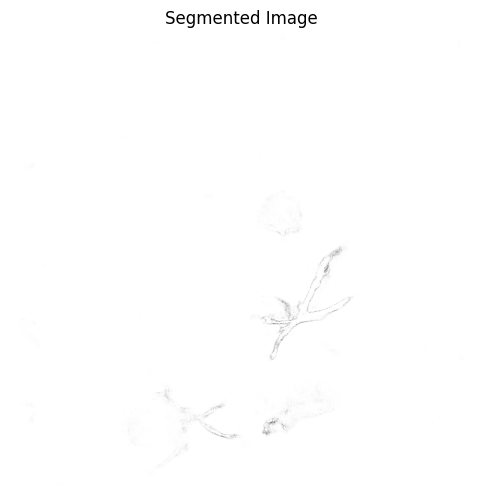

In [27]:
foreground_path = "./foreground.png"
foreground.save(foreground_path)

plt.figure(figsize=(6, 6))
plt.imshow(foreground)
plt.title("Segmented Image")
plt.axis("off")
plt.show()

## Отчистка от шума

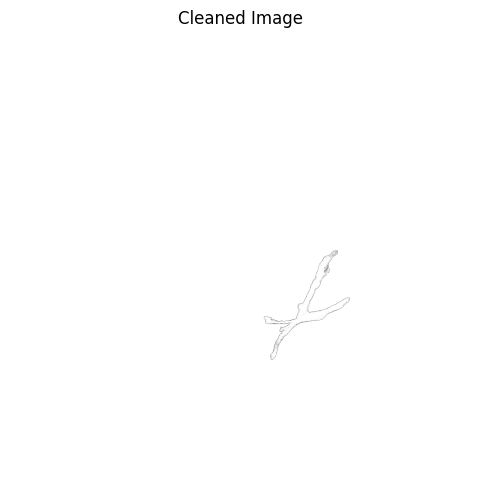

True

In [28]:
image = cv2.imread(foreground_path, cv2.IMREAD_UNCHANGED)
b, g, r, a = cv2.split(image)
_, mask = cv2.threshold(a, 127, 255, cv2.THRESH_OTSU)

kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

min_area = 500
filtered_mask = np.zeros_like(mask)

for contour in contours:
    if cv2.contourArea(contour) > min_area:
        cv2.drawContours(filtered_mask, [contour], -1, 255, thickness=cv2.FILLED)

b = cv2.bitwise_and(b, filtered_mask)
g = cv2.bitwise_and(g, filtered_mask)
r = cv2.bitwise_and(r, filtered_mask)
a = cv2.bitwise_and(a, filtered_mask)

result = cv2.merge((b, g, r, a))

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGRA2RGBA))
plt.title("Cleaned Image")
plt.axis("off")
plt.show()

cv2.imwrite("cleaned_image.png", result)

## Нахождение центра масс астроцита

In [29]:
image = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
full_image = cv2.imread(file)

_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_OTSU)

binary_image = cv2.dilate(binary_image, np.ones((5, 5), np.uint8), iterations=1)
binary_image = cv2.erode(binary_image, np.ones((3, 3), np.uint8), iterations=1)

# ---- Центр масс ----
white_pixels = np.argwhere(binary_image == 255)
center_of_mass = white_pixels.mean(axis=0).astype(int)
center_of_mass = tuple(center_of_mass[::-1])  # (y, x) → (x, y)

# Анализ плотности пикселей
projection_x = np.sum(binary_image, axis=0)
projection_y = np.sum(binary_image, axis=1)

max_x = np.argmax(projection_x)
max_y = np.argmax(projection_y)

# Корректируем центр масс
corrected_center = (
    (center_of_mass[0] + max_x) // 2,
    (center_of_mass[1] + max_y) // 2
)

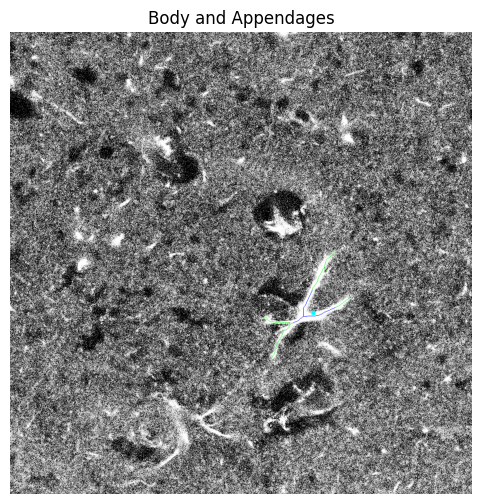

In [30]:
# ---- Скелетизация ----
skeleton = morphology.skeletonize(binary_image // 255)
skeleton_pixels = np.argwhere(skeleton == 1)

# ---- Разделяем по радиусу ----
distances = np.linalg.norm(skeleton_pixels - np.array(corrected_center[::-1]), axis=1)

# Порог радиуса
threshold_radius = np.percentile(distances, 35)

body_pixels = skeleton_pixels[distances <= threshold_radius]
branch_pixels = skeleton_pixels[distances > threshold_radius]

image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
if full_image is not None:
    image_color = full_image

# Красим тело и ветви
for pixel in body_pixels:
    image_color[pixel[0], pixel[1]] = [255, 0, 0]  # Красный (тело)
for pixel in branch_pixels:
    image_color[pixel[0], pixel[1]] = [0, 255, 0]  # Зеленый (ветви)

cv2.circle(image_color, corrected_center, radius=5, color=(255, 255, 0), thickness=-1)
cv2.imwrite("result.png", image_color)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.title("Body and Appendages")
plt.axis("off")
plt.show()
